# 📦 Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import random

# 📁 Paths & Constants

In [2]:
DATASET_PATH = 'dataset'
TEST_PATH = os.path.join(DATASET_PATH, 'test')
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 32
MODEL_PATH = 'smile_cnn_model.h5'

# 🔍 EDA: Visualize Class Distribution and Images

Classes: ['non_smile', 'smile']
non_smile: 603 images
smile: 600 images


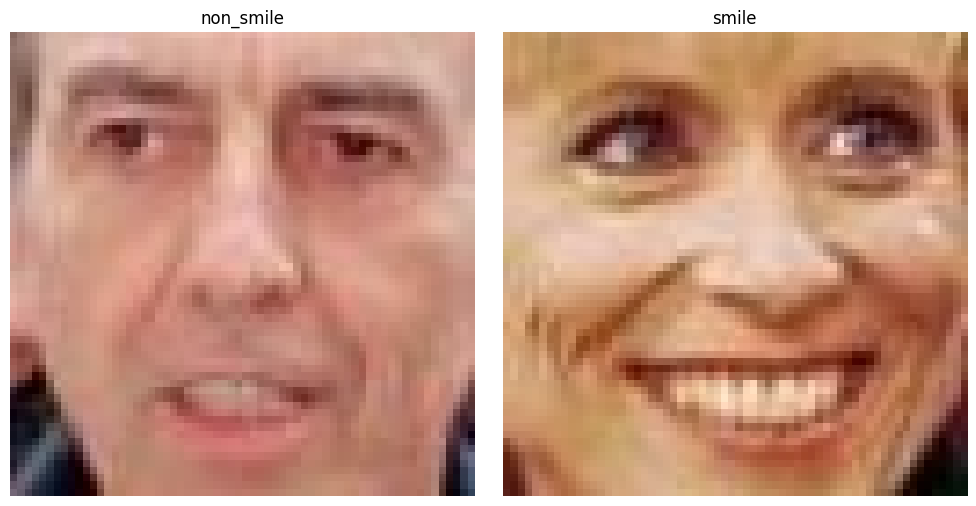

In [3]:
# List class folders (excluding 'test')
class_dirs = [d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d)) and d != 'test']

print("Classes:", class_dirs)

# Count images per class
for cls in class_dirs:
    num_imgs = len(os.listdir(os.path.join(DATASET_PATH, cls)))
    print(f"{cls}: {num_imgs} images")

# Show sample images
fig, axes = plt.subplots(1, len(class_dirs), figsize=(10, 5))

for i, cls in enumerate(class_dirs):
    img_path = os.path.join(DATASET_PATH, cls, random.choice(os.listdir(os.path.join(DATASET_PATH, cls))))
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMAGE_SIZE)
    axes[i].imshow(img)
    axes[i].set_title(cls)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# 🧪 Data Generators with Augmentation and Validation Split

In [4]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['non_smile', 'smile'],
    subset='training'
)

val_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['non_smile', 'smile'],
    subset='validation'
)

Found 963 images belonging to 2 classes.
Found 240 images belonging to 2 classes.


# 🏗️ CNN Model Definition

In [5]:
def build_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model(input_shape=(*IMAGE_SIZE, 3))
model.summary()


/Users/andrew/Desktop/Projects/memryx/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,329 (2.61 MB)

 Trainable params: 683,329 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

# 🏃‍♂️ Training the Model

In [6]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint(MODEL_PATH, save_best_only=True)
]

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=100,
    callbacks=callbacks
)

/Users/andrew/Desktop/Projects/memryx/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4961 - loss: 0.6967

/Users/andrew/Desktop/Projects/memryx/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.4963 - loss: 0.6967 - val_accuracy: 0.6920 - val_loss: 0.6895
Epoch 2/100
 1/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5000 - loss: 0.6935

/Users/andrew/Desktop/Projects/memryx/.venv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5000 - loss: 0.6935 - val_accuracy: 0.5938 - val_loss: 0.6899
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5848 - loss: 0.6861

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5848 - loss: 0.6857 - val_accuracy: 0.7098 - val_loss: 0.6346
Epoch 4/100
 1/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6875 - loss: 0.6512

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6875 - loss: 0.6512 - val_accuracy: 0.7098 - val_loss: 0.6302
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6245 - loss: 0.6575

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.6252 - loss: 0.6569 - val_accuracy: 0.7321 - val_loss: 0.5780
Epoch 6/100
 1/30 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6250 - loss: 0.6166

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6250 - loss: 0.6166 - val_accuracy: 0.7455 - val_loss: 0.5598
Epoch 7/100
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7094 - loss: 0.5640

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7127 - loss: 0.5622 - val_accuracy: 0.8080 - val_loss: 0.4465
Epoch 8/100
 1/30 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.7500 - loss: 0.4694

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7500 - loss: 0.4694 - val_accuracy: 0.7946 - val_loss: 0.4249
Epoch 9/100
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7758 - loss: 0.4699

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7779 - loss: 0.4689 - val_accuracy: 0.8125 - val_loss: 0.4125
Epoch 10/100
 1/30 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7812 - loss: 0.5104

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7812 - loss: 0.5104 - val_accuracy: 0.8393 - val_loss: 0.4078
Epoch 11/100
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8008 - loss: 0.4430

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8012 - loss: 0.4414 - val_accuracy: 0.8750 - val_loss: 0.3532
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7812 - loss: 0.5982 - val_accuracy: 0.8304 - val_loss: 0.4700
Epoch 13/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.8262 - loss: 0.4144 - val_accuracy: 0.8348 - val_loss: 0.3753
Epoch 14/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9062 - loss: 0.3056 - val_accuracy: 0.8571 - val_loss: 0.3758
Epoch 15/100
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8479 - loss: 0.3738

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8487 - loss: 0.3720 - val_accuracy: 0.8750 - val_loss: 0.3264
Epoch 16/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9062 - loss: 0.2328 - val_accuracy: 0.8571 - val_loss: 0.3457
Epoch 17/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8581 - loss: 0.3644 - val_accuracy: 0.8616 - val_loss: 0.3333
Epoch 18/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9062 - loss: 0.3013 - val_accuracy: 0.8616 - val_loss: 0.3684
Epoch 19/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.8792 - loss: 0.3319 - val_accuracy: 0.8348 - val_loss: 0.3576
Epoch 20/100
 1/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 1.0000 - loss: 0.2003

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.2003 - val_accuracy: 0.8884 - val_loss: 0.3150
Epoch 21/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8934 - loss: 0.3332 - val_accuracy: 0.8616 - val_loss: 0.3218
Epoch 22/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8750 - loss: 0.2877 - val_accuracy: 0.8661 - val_loss: 0.3388
Epoch 23/100
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8522 - loss: 0.3474

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.8535 - loss: 0.3449 - val_accuracy: 0.8973 - val_loss: 0.3113
Epoch 24/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8750 - loss: 0.3866 - val_accuracy: 0.8661 - val_loss: 0.3247
Epoch 25/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8863 - loss: 0.2787 - val_accuracy: 0.8616 - val_loss: 0.3518
Epoch 26/100
 1/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8125 - loss: 0.4776

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8125 - loss: 0.4776 - val_accuracy: 0.8705 - val_loss: 0.2986
Epoch 27/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8851 - loss: 0.2891 - val_accuracy: 0.8438 - val_loss: 0.4134
Epoch 28/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8125 - loss: 0.3082 - val_accuracy: 0.8438 - val_loss: 0.3446
Epoch 29/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8806 - loss: 0.3059 - val_accuracy: 0.8795 - val_loss: 0.3032
Epoch 30/100
 1/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8750 - loss: 0.4791

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8750 - loss: 0.4791 - val_accuracy: 0.9018 - val_loss: 0.2771
Epoch 31/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8987 - loss: 0.2720 - val_accuracy: 0.8438 - val_loss: 0.3805
Epoch 32/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8750 - loss: 0.2656 - val_accuracy: 0.8438 - val_loss: 0.3824
Epoch 33/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8805 - loss: 0.3083 - val_accuracy: 0.8036 - val_loss: 0.4097
Epoch 34/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8438 - loss: 0.5593 - val_accuracy: 0.8348 - val_loss: 0.3745
Epoch 35/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8641 - loss: 0.3672 - val_accuracy: 0.8795 - val_loss: 0.2907
Epoch 36/100
 1/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9062 - loss: 0.2524

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9062 - loss: 0.2524 - val_accuracy: 0.9107 - val_loss: 0.2486
Epoch 37/100
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9081 - loss: 0.2571

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9078 - loss: 0.2571 - val_accuracy: 0.9241 - val_loss: 0.2227
Epoch 38/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8438 - loss: 0.4707 - val_accuracy: 0.8839 - val_loss: 0.2585
Epoch 39/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8973 - loss: 0.2680 - val_accuracy: 0.8571 - val_loss: 0.3283
Epoch 40/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8438 - loss: 0.2579 - val_accuracy: 0.8482 - val_loss: 0.3673
Epoch 41/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9092 - loss: 0.2469 - val_accuracy: 0.8750 - val_loss: 0.2998
Epoch 42/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9375 - loss: 0.1963 - val_accuracy: 0.8616 - val_loss: 0.2807
Epoch 43/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8905 - loss: 0.2618 - val_accuracy: 0.8527 - val_loss: 0.2886
Epoch 44/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9688 - loss: 0.1937 - val_accuracy: 0.8304 - va

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9062 - loss: 0.1619 - val_accuracy: 0.9062 - val_loss: 0.2204
Epoch 47/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8952 - loss: 0.2716 - val_accuracy: 0.8929 - val_loss: 0.2581
Epoch 48/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0933 - val_accuracy: 0.9018 - val_loss: 0.2536
Epoch 49/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9220 - loss: 0.2169

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9216 - loss: 0.2176 - val_accuracy: 0.9286 - val_loss: 0.2034
Epoch 50/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9375 - loss: 0.2053 - val_accuracy: 0.8661 - val_loss: 0.2640
Epoch 51/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9155 - loss: 0.2151 - val_accuracy: 0.9018 - val_loss: 0.2284
Epoch 52/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9062 - loss: 0.1402 - val_accuracy: 0.8929 - val_loss: 0.2471
Epoch 53/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8991 - loss: 0.2429 - val_accuracy: 0.8527 - val_loss: 0.3999
Epoch 54/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8438 - loss: 0.5008 - val_accuracy: 0.9018 - val_loss: 0.2739
Epoch 55/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9083 - loss: 0.2357 - val_accuracy: 0.9107 - val_loss: 0.2220
Epoch 56/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9688 - loss: 0.1272 - val_accuracy: 0.8929 - va

# 📈 Plot Training History

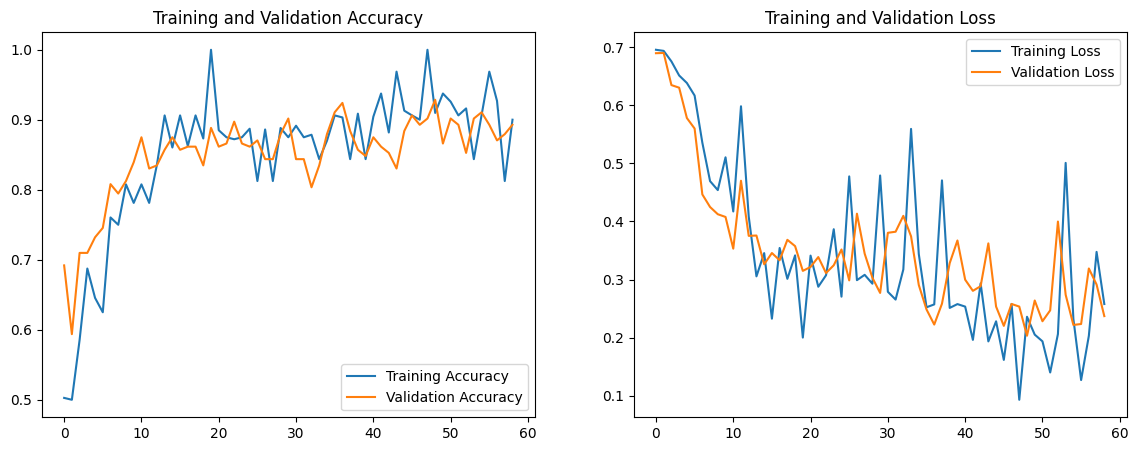

In [7]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

plot_history(history)

# ✅ Evaluate Model on Validation Set

In [8]:
val_loss, val_acc = model.evaluate(val_generator, verbose=1)
print(f"\nValidation Accuracy: {val_acc:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9151 - loss: 0.2077

Validation Accuracy: 0.89


# 🔬 Test Set Evaluation


📦 Test Directory Found
Found 12030 images belonging to 1 classes.
12030/12030 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step

Note: Test set has no labels, so accuracy cannot be calculated.
Predictions for test images are available in `predictions`.


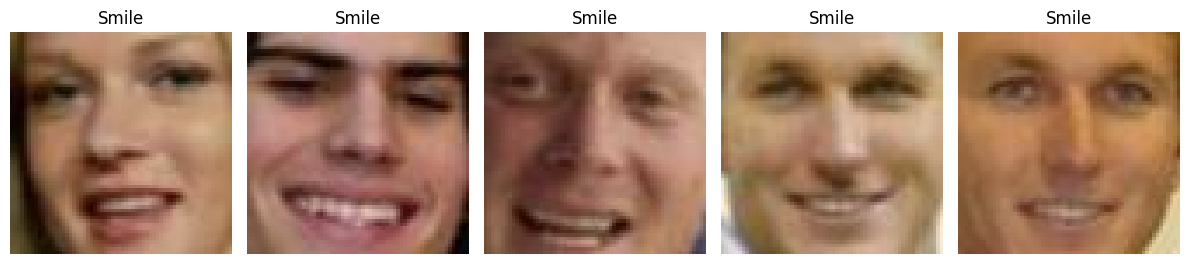

In [9]:
if os.path.exists(TEST_PATH):
    print("\n📦 Test Directory Found")
    
    test_datagen = ImageDataGenerator(rescale=1./255)

    test_generator = test_datagen.flow_from_directory(
        DATASET_PATH,
        classes=['test'],
        target_size=IMAGE_SIZE,
        batch_size=1,
        shuffle=False,
        class_mode=None
    )
    
    predictions = model.predict(test_generator)
    
    # Since the test folder doesn't contain labels, we can't compute accuracy
    print("\nNote: Test set has no labels, so accuracy cannot be calculated.")
    print("Predictions for test images are available in `predictions`.")

    # Optional: Visualize predictions
    test_image_paths = test_generator.filepaths
    plt.figure(figsize=(12, 6))
    for i in range(min(5, len(predictions))):
        img = tf.keras.preprocessing.image.load_img(test_image_paths[i], target_size=IMAGE_SIZE)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Smile' if predictions[i] > 0.5 else 'No Smile')
    plt.tight_layout()
    plt.show()